# Daily statistics from six-hourly SEAS5 data

In [1]:
# If first time running, uncomment the line below to install any additional dependancies
# !bash requirements-for-notebooks.sh

In [1]:
from earthkit import aggregate as ek_aggregate
from earthkit import data as ek_data

from earthkit.data.testing import earthkit_remote_test_data_file
ek_data.settings.set("cache-policy", "user")

import matplotlib.pyplot as plt

## Load some test data

All `earthkit-climate` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray`.

In this example we will use three initialisation of the SEAS5 2m temperature data on a 1.x1. spatial grid. The temporal resolution is 6 hourly, and we have the forecasts for January, February and March 2015.

First we download (if not already cached) lazily load the SEAS5 data (please see tutorials in `earthkit-data` for more details in cache management).

We inspect the data using the to_xarray method and see we have some 2m air temperature data. Using the xarray representation each of the dimensions can be queried.

In [2]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
remote_seas5_file = earthkit_remote_test_data_file("test-data", "seas5_2m_temperature_201501-201503_europe_1deg.grib")
seas5_data = ek_data.from_source("url", remote_seas5_file)
seas5_xr = seas5_data.to_xarray()
seas5_data.to_xarray()

Recovering from connection error [HTTPSConnectionPool(host='get.ecmwf.int', port=443): Max retries exceeded with url: /repository/test-data/earthkit-data/test-data/seas5_2m_temperature_201501-201503_europe_1deg.grib (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x14df584d0>, 'Connection to get.ecmwf.int timed out. (connect timeout=30)'))], attemps 1 of 500
Retrying in 120 seconds


<xarray.Dataset> Size: 91MB
Dimensions:     (number: 25, time: 3, step: 239, surface: 1, latitude: 31,
                 longitude: 41)
Coordinates:
  * number      (number) int64 200B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 24B 2015-01-01 2015-02-01 2015-03-01
  * step        (step) timedelta64[ns] 2kB 0 days 06:00:00 ... 59 days 18:00:00
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude   (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
    valid_time  (time, step) datetime64[ns] 6kB ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 91MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-26T15:35 GRIB to CDM+CF via cfgrib-0.9.1...

## Calculate the daily mean of the Seasonal Forecast data

In this first example we will handle the forecast initialisations independently, i.e. return the daily mean of the 3 different forescasts. To do this we must specifiy that the time-dimension we wish to calculate the aggregation over is the "step" dimension.

In [4]:
seas_median = ek_aggregate.temporal.reduce(seas5_xr, how="median") # , q=0.5)
seas_median

<xarray.Dataset> Size: 30MB
Dimensions:     (number: 25, step: 239, surface: 1, latitude: 31, longitude: 41)
Coordinates:
  * number      (number) int64 200B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * step        (step) timedelta64[ns] 2kB 0 days 06:00:00 ... 59 days 18:00:00
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude   (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
Data variables:
    t2m_median  (number, step, surface, latitude, longitude) float32 30MB 270...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-26T15:34 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
seas5_daily_mean = ek_aggregate.temporal.daily_mean(seas5_data, time_dim="valid_time")
seas5_daily_mean

<xarray.Dataset> Size: 15MB
Dimensions:     (number: 25, surface: 1, latitude: 31, longitude: 41,
                 valid_time: 119)
Coordinates:
  * number      (number) int64 200B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23 24
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude   (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
  * valid_time  (valid_time) object 952B 2015-01-01 2015-01-02 ... 2015-04-29
Data variables:
    t2m_mean    (valid_time, number, surface, latitude, longitude) float32 15MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-26T10:36 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
seas5_daily_mean = ek_aggregate.temporal.daily_mean(seas5_data, time_dim="step", time_shift={"hours": 9})
seas5_daily_mean

<xarray.Dataset> Size: 23MB
Dimensions:    (number: 25, time: 3, surface: 1, latitude: 31, longitude: 41,
                step: 60)
Coordinates:
  * number     (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * time       (time) datetime64[ns] 24B 2015-01-01 2015-02-01 2015-03-01
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude  (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
  * step       (step) timedelta64[ns] 480B 0 days 15:00:00 ... 59 days 15:00:00
Data variables:
    t2m        (step, number, time, surface, latitude, longitude) float32 23MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-26T08:56 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
seas5_daily_sum = ek_aggregate.temporal.daily_sum(seas5_data, time_dim="valid_time")
seas5_daily_sum

<xarray.Dataset> Size: 15MB
Dimensions:    (number: 25, surface: 1, latitude: 31, longitude: 41, date: 119)
Coordinates:
  * number     (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude  (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
  * date       (date) object 952B 2015-01-01 2015-01-02 ... 2015-04-29
Data variables:
    t2m_sum    (date, number, surface, latitude, longitude) float32 15MB 808....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-26T08:56 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
# seas5_xr.valid_time.values[0][0]
groups = seas5_xr.groupby('valid_time.date')
groups.sum()

<xarray.Dataset> Size: 15MB
Dimensions:    (number: 25, surface: 1, latitude: 31, longitude: 41, date: 119)
Coordinates:
  * number     (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude  (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
  * date       (date) object 952B 2015-01-01 2015-01-02 ... 2015-04-29
Data variables:
    t2m        (date, number, surface, latitude, longitude) float32 15MB 808....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-26T08:55 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
import pandas as pd
pd.to_datetime(seas5_xr.step.values)

TypeError: dtype timedelta64[ns] cannot be converted to datetime64[ns]

In [ ]:
seas5_daily_mean = ek_aggregate.temporal.daily_mean(seas5_data, time_dim="step")
seas5_daily_mean

ValueError: Invalid frequency 'date' - see xarray documentation for a full list of valid frequencies.

In [ ]:
seas5_valid_time = seas5_data.to_xarray().stack(valid_time=("time", "step"))
seas5_valid_time2 = seas5_data.to_xarray().stack(valid_time=("time", "step"))
seas5_valid_time

KeyboardInterrupt: 

In [ ]:
grouped = seas5_xr.groupby("valid_time.date")
dir(grouped)

['_HANDLED_TYPES',
 '__add__',
 '__and__',
 '__annotations__',
 '__array_ufunc__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__or__',
 '__orig_bases__',
 '__parameters__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_binary_op',
 '_bins',
 '_codes',
 '_combine',
 '_cum_extra_args_docstring',
 '_dims',
 '_first_or_last',
 '_flox_reduce',
 '_full_index',
 '

DatasetGroupBy, grouped over 'date'
119 groups with labels 2015-01-01, ..., 2015-04-29.

In [ ]:
# 
# seas5_xr.groupby("valid_time.date").mean()
seas5_xr.groupby("step.days").mean()

<xarray.Dataset> Size: 23MB
Dimensions:    (number: 25, time: 3, surface: 1, latitude: 31, longitude: 41,
                days: 60)
Coordinates:
  * number     (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * time       (time) datetime64[ns] 24B 2015-01-01 2015-02-01 2015-03-01
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude  (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
  * days       (days) int64 480B 0 1 2 3 4 5 6 7 8 ... 52 53 54 55 56 57 58 59
Data variables:
    t2m        (days, number, time, surface, latitude, longitude) float32 23MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-25T16:04 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
# seas5_valid_time.assign_coords({"valid_time": seas5_data.to_xarray()["valid_time"].squeeze()})
seas5_xr = seas5_data.to_xarray()
valid_time_vals = seas5_xr["valid_time"].values.flatten()
valid_time_attrs = seas5_xr["valid_time"].attrs
seas5_valid_time = seas5_valid_time.assign_coords({"valid_time": valid_time_vals})
seas5_valid_time["valid_time"] = seas5_valid_time["valid_time"].assign_attrs(valid_time_attrs)
seas5_valid_time
seas5_valid_time.groupby("valid_time.date").mean()

<xarray.Dataset> Size: 15MB
Dimensions:    (number: 25, surface: 1, latitude: 31, longitude: 41, date: 119)
Coordinates:
  * number     (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude  (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
  * date       (date) object 952B 2015-01-01 2015-01-02 ... 2015-04-29
Data variables:
    t2m        (date, number, surface, latitude, longitude) float32 15MB 269....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-25T15:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
seas5_valid_time.groupby("valid_time.date").mean()

<xarray.Dataset> Size: 15MB
Dimensions:    (number: 25, surface: 1, latitude: 31, longitude: 41, date: 119)
Coordinates:
  * number     (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * surface    (surface) float64 8B 0.0
  * latitude   (latitude) float64 248B 70.0 69.0 68.0 67.0 ... 42.0 41.0 40.0
  * longitude  (longitude) float64 328B -10.0 -9.0 -8.0 -7.0 ... 28.0 29.0 30.0
  * date       (date) object 952B 2015-01-01 2015-01-02 ... 2015-04-29
Data variables:
    t2m        (date, number, surface, latitude, longitude) float32 15MB 269....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-25T15:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
seas5_xr = seas5_data.to_xarray()
seas5_xr.groupby("valid_time.date")

DatasetGroupBy, grouped over 'date'
119 groups with labels 2015-01-01, ..., 2015-04-29.

## Calculate a rolling mean with a 50 timestep window

<xarray.Dataset> Size: 330MB
Dimensions:     (number: 1, time: 1460, step: 1, surface: 1, latitude: 201,
                 longitude: 281)
Coordinates:
  * number      (number) int64 8B 0
  * time        (time) datetime64[ns] 12kB 2015-01-01 ... 2015-12-31T18:00:00
  * step        (step) timedelta64[ns] 8B 00:00:00
  * surface     (surface) float64 8B 0.0
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
    valid_time  (time, step) datetime64[ns] 12kB dask.array<chunksize=(1460, 1), meta=np.ndarray>
Data variables:
    t2m_mean    (number, time, step, surface, latitude, longitude) float32 330MB dask.array<chunksize=(1, 1459, 1, 1, 201, 281), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-25T13:47 GRIB to CDM+CF via cfgrib-0.9.1...

## Plot a random point location to see the different aggregation methods

Text(0.5, 1.0, 'Aggregation methods')

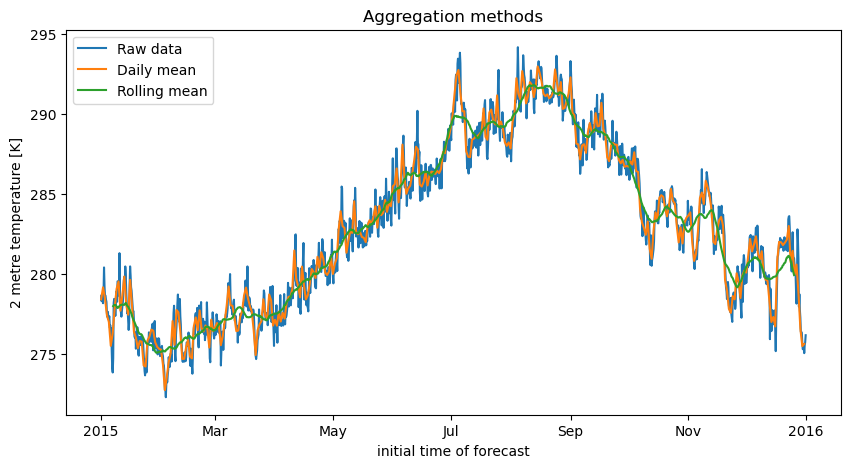

In [ ]:
isel_kwargs = {"latitude":100, "longitude":100}

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))

era5_data.to_xarray().t2m.isel(**isel_kwargs).plot(label='Raw data', ax=ax)
era5_daily_mean.t2m.isel(**isel_kwargs).plot(label='Daily mean', ax=ax)
era5_rolling.t2m_mean.isel(**isel_kwargs).plot(label='Rolling mean', ax=ax)
# figure = fig[0].get_figure()
ax.legend(loc=2)
ax.set_title("Aggregation methods")

In [ ]:
rolling_kwargs =  {'time': 50, 'center': True}
reduce_kwargs =  {}
data_rolling = era5_data.to_xarray().rolling(**rolling_kwargs)
data_rolling

DatasetRolling [time->50(center)]

In [ ]:
ek_aggregate.temporal.reduce(data_rolling)

Cannot find a wrapper for class: xarray.core.rolling.DatasetRolling, returning unwrapped object
Cannot find a wrapper for class: xarray.core.rolling.DatasetRolling, returning unwrapped object


AttributeError: 'Dataset' object has no attribute 'name'